In [4]:
from scipy.stats import ttest_1samp, zscore
from statsmodels.stats.multitest import multipletests
import numpy as np
import pickle
from seaborn import heatmap

In [2]:
with open('FC_IHB.pickle', 'rb') as handle:
    data = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'FC_IHB.pickle'

In [58]:
data.keys()

dict_keys(['AAL_aCompCor10_24P', 'HCPex_aCompCor10_24P', 'Schaefer200_aCompCor10_24P', 'Schaefer200_24P', 'HCPex_24P', 'AAL_24P'])

In [29]:
opened, closed = data['Schaefer200_aCompCor10_24P']

In [5]:
closed = np.load('/home/tm/projects/OpenCloseProject/notebooks/closed_ihb.npy')
opened = np.load('/home/tm/projects/OpenCloseProject/notebooks/opened_ihb.npy')

closed = zscore(closed)
opened = zscore(opened)

#opened = np.load('/home/tm/opened_china6.npy')
#closed = np.load('/home/tm/closed_china6.npy')

<Axes: >

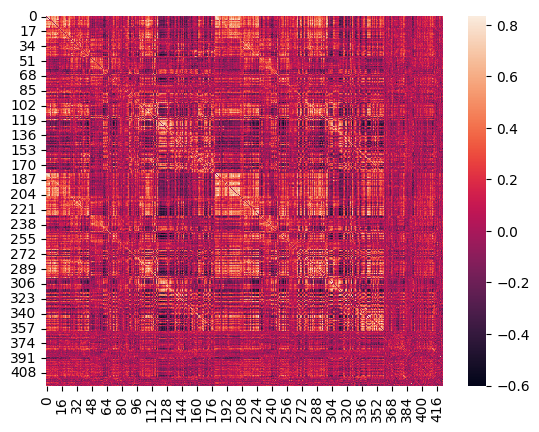

In [22]:
heatmap(opened[0])
plt.title('')

In [14]:
from nilearn.connectome import ConnectivityMeasure

def fc_calc(data):
    con = ConnectivityMeasure(kind='correlation', standardize=False)
    fc_cl = con.fit_transform(data)
    for i in fc_cl:
        np.fill_diagonal(i, 0)
    return fc_cl


closed = fc_calc(closed)
opened = fc_calc(opened)

In [25]:
def group_diff(op, cl):
    return round(np.mean(op - cl), 3), round(np.mean(np.arctanh(op) - np.arctanh(cl)), 3)

In [30]:
group_diff(opened, closed)

(-0.082, -0.094)

| Strategy | 24       | Compcor  |
|----------|----------|----------|
| Schaefer | -0.02, -0.023    | -0.082, -0.094     |
| AAL      | -0.018, -0.02    | -0.012, -0.014    |
| HCPex    | -0.013, -0.014| -0.01, -0.011     |

# t-stat

In [15]:
t_stat, p_val = ttest_1samp(opened - closed, 0)

In [20]:
_, _, alphacSidak, _ = multipletests(p_val.reshape(-1), 0.001)

<Axes: >

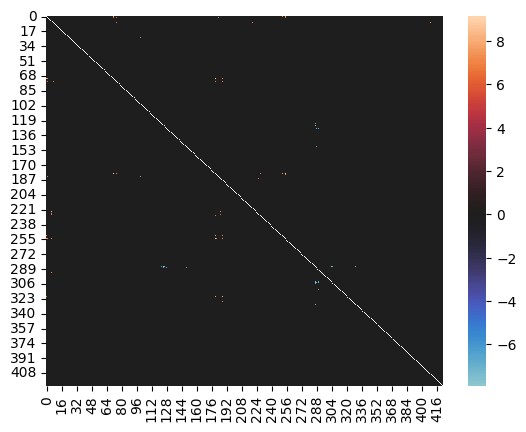

In [21]:
test_sidak = p_val < alphacSidak
heatmap(t_stat * (p_val < alphacSidak), center=0)

In [35]:
test_001 = p_val < alphacSidak #0.001
closed_001 = closed * np.array([test_001 for i in range(len(closed_ihb))])
opened_001 = opened_ihb * np.array([test_001 for i in range(len(opened_ihb))])

In [23]:
from nilearn import connectome
close_vec = connectome.sym_matrix_to_vec(closed, discard_diagonal=False)
open_vec = connectome.sym_matrix_to_vec(opened, discard_diagonal=False)

In [24]:
x = np.concatenate([close_vec, open_vec])
y = [0 for i in range(len(close_vec))] + [1 for i in range(len(open_vec))]

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

lr = LogisticRegression()
#lr.fit(x_train, y_train)
#lr.score(x_test, y_test)

cv_results = cross_validate(lr, x, y, cv=10)
np.mean(cv_results['test_score'])

0.85625

p-value < 0.001

| Strategy | 24       | Compcor  |
|----------|----------|----------|
| Schaefer | 0.885    | 0.87     |
| AAL      | 0.866    | 0.89     |
| HCPex    | 0.891    | 0.95     |


Sidak correction

| Strategy | 24       | Compcor  |
|----------|----------|----------|
| Schaefer | 0.898    | 0.83     |
| AAL      | 0.812    | 0.84     |
| HCPex    | 0.884    | 0.91     |
